In [2]:
import splat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib
import wisps
import wisps.simulations as wispsim
import seaborn as sns
import matplotlib.colors as mcolors

from astropy.coordinates import SkyCoord
import astropy.coordinates as astrocoord
import astropy.units as u

import matplotlib as mpl
mpl.rcParams['font.size'] = 18
%matplotlib inline

In [3]:
#MIX MY COLORMAP WITH COOOLWARM 
colors1 = plt.cm.coolwarm(np.linspace(0., 1, 256))
colors2=plt.cm.YlOrBr(np.linspace(0., 1, 256))
colors = np.vstack((colors1+colors1)/2)
mymap=mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [4]:
mymap_r=mymap.reversed(name='revers')

In [5]:
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.Series(x.indices)
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]
    
def classify_by_templates(s):
    spt=s.spectral_type[0]
    spt_unc=s.spectral_type[1]
    if spt_unc== 0.0: spt_unc=1
        
    if spt<20:
        pass
        
    return 

def reclassify(s):
    if s is None:
        return None
    spt_unc=s.spectral_type[1]
    
    if abs(spt_unc) > 1:
        s.classify_by_standard(comprange=[1.15, 1.65])
        s.calculate_distance(use_spt_unc=True, use_index_type=False)
    else:
        s.calculate_distance(use_spt_unc=True, use_index_type=False)
    return s
    


In [6]:
#read in the data
cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.h5', key='all')

In [7]:
spectra= [reclassify(x) for x in cands0.spectra]

In [8]:
cands0['spectra']=spectra

In [9]:
cands=cands0.spectra.apply(get_indices)
cands['spectra']=cands0.spectra

In [10]:
cands['grism_id']=cands0.grism_id
cands['spt']=cands0.spectra.apply(get_spt)

In [11]:
canddf=cands[~cands.spectra.isna()].reset_index(drop=True)

In [12]:
canddf['spt']=canddf.spectra.apply(lambda x: x.spectral_type[0])
canddf['spt_er']=canddf.spectra.apply(lambda x: x.spectral_type[1])
canddf['distance']=canddf.spectra.apply(lambda x: x.distance['val'].value)
canddf['distance_er']=canddf.spectra.apply(lambda x: x.distance['er'].value)
canddf['coord']=canddf.spectra.apply(lambda x:x.coords)
canddf['designation']=canddf.spectra.apply(lambda x: x.designation)
#canddf['index_type_er']=canddf.spectra.apply(lambda x: x.index_type[1])

In [14]:
canddfj=canddf.join(canddf.spectra.apply(lambda x: pd.Series(x.mags)))
canddff=canddfj.join(canddf.spectra.apply(lambda x: pd.Series(x.snr)))
canddff['spectra']=canddf.spectra

canddff=canddff.drop_duplicates('designation')

In [15]:
ucds=wisps.Annotator.reformat_table((canddff[(canddff.spt>=17) &(canddff.snr1 >=3.)]).reset_index(drop=True)).sort_values(by='spt')

In [16]:
#remove some objects by name
ucds=(ucds[~ ucds.grism_id.isin(['par199-00124'])]).reset_index(drop=True).sort_values(by='spt')

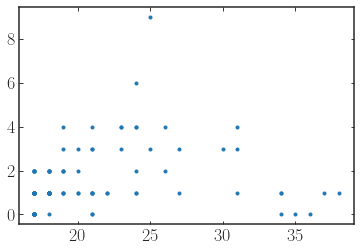

In [17]:
fig, ax=plt.subplots()
plt.plot(ucds.spt, ucds.spt_er, '.')

In [18]:
OBSERVED_POINTINGS =pd.read_pickle(wisps.OUTPUT_FILES+'/pointings.pkl')


In [19]:
mdwarfs=(ucds.sort_values('spt')[ucds.spt.between(17, 20)])
ldwarfs=(ucds.sort_values('spt')[ucds.spt.between(20, 30)])
tdwarfs=(ucds.sort_values('spt')[ucds.spt.between(30, 40)])

coords=SkyCoord(ucds.coord.values)

galoc=coords.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))
x, y, z=galoc.cartesian.xyz

r=(x**2+y**2)**0.5

ucds['pointing']=ucds.grism_id.apply(wispsim.get_proper_pointing)
pntcoords=SkyCoord([x.coord for x in OBSERVED_POINTINGS 
                    if not (x.name.lower() in ucds.pointing.str.lower().values)])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


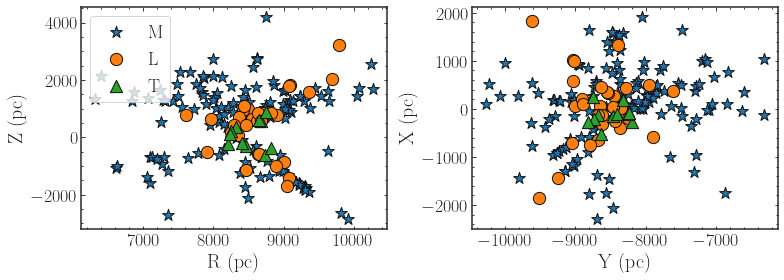

In [20]:
fig, (ax, ax1)=plt.subplots(figsize=(11, 4), ncols=2)

sc=ax.scatter(r[mdwarfs.index], z[mdwarfs.index], s=150, cmap='coolwarm',  marker='*', edgecolors='#111111', label='M')
sc=ax.scatter(r[ldwarfs.index], z[ldwarfs.index], s=150, cmap='coolwarm',  marker='o', edgecolors='#111111', label='L')
sc=ax.scatter(r[tdwarfs.index], z[tdwarfs.index], s=150, cmap='coolwarm',  marker='^', edgecolors='#111111', label='T')

ax.minorticks_on()

sc=ax1.scatter(x[mdwarfs.index], y[mdwarfs.index], s=150, cmap='coolwarm',  marker='*', edgecolors='#111111')
sc=ax1.scatter(x[ldwarfs.index], y[ldwarfs.index], s=150, cmap='coolwarm',  marker='o', edgecolors='#111111')
sc=ax1.scatter(x[tdwarfs.index], y[tdwarfs.index], s=150, cmap='coolwarm',  marker='^', edgecolors='#111111')

ax.minorticks_on()



ax.set_ylabel('Z (pc)', fontsize=20)
ax.set_xlabel('R (pc)', fontsize=20)
ax1.set_ylabel('X (pc)', fontsize=20)
ax1.set_xlabel('Y (pc)', fontsize=20)

ax.minorticks_on()
ax1.minorticks_on()


#add the sun
#Rsun=83000.
#Zsun=27.

#ax1.scatter(0., 0.)
#ax.scatter(8300, 27., marker='')
ax.legend()
#plt.grid(color='#7FDBFF')
#mplcyberpunk.make_lines_glow(ax)
#mplcyberpunk.make_lines_glow(ax1)


plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf', bbox_inches='tight')

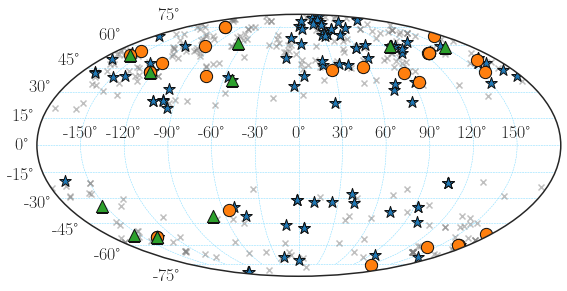

In [21]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(pntcoords.galactic.l.wrap_at(180*u.deg).radian, pntcoords.galactic.b.wrap_at(180*u.deg).radian, c='grey', marker='x', alpha=0.5)

c=ax.scatter(galoc.galactic.l.wrap_at(180*u.deg).radian[mdwarfs.index], galoc.galactic.b.wrap_at(180*u.deg).radian[mdwarfs.index], 
             marker='*', edgecolors='#111111', s=150)
c=ax.scatter(galoc.galactic.l.wrap_at(180*u.deg).radian[ldwarfs.index], galoc.galactic.b.wrap_at(180*u.deg).radian[ldwarfs.index], 
             marker='o', edgecolors='#111111', s=150)
c=ax.scatter(galoc.galactic.l.wrap_at(180*u.deg).radian[tdwarfs.index], galoc.galactic.b.wrap_at(180*u.deg).radian[tdwarfs.index], 
             marker='^', edgecolors='#111111', s=150)




             

#plt.xlabel("l", fontsize=18)
#plt.ylabel("b", fontsize=18)
plt.grid(color='#7FDBFF')
plt.minorticks_on()
#mplcyberpunk.make_lines_glow(ax)

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_skymap.pdf', bbox_inches='tight')

In [22]:
4*533*0.1

213.20000000000002

In [23]:
bucds=abs(galoc.galactic.b.wrap_at(180*u.deg).to(u.deg).value)
bpnts=abs(pntcoords.galactic.l.wrap_at(180*u.deg).to(u.deg).value)

areanorth= len(bpnts[np.logical_and(bpnts >0, bpnts <= 30.) ])*4.1*(u.arcmin**2)
areamid= len(bpnts[np.logical_and(bpnts >30, bpnts <= 60.) ])*4.1*(u.arcmin**2)
areasouth= len(bpnts[np.logical_and(bpnts >30, bpnts <= 90.) ])*4.1*(u.arcmin**2)

print ('ucds density in north {}'.format(len(bucds[np.logical_and(bucds >0, bucds <= 30.) ])/areanorth))
print ('ucds density in middle {}'.format(len(bucds[np.logical_and(bucds >30, bucds <=60) ])/areamid))
print ('ucds density in south {}'.format(len(bucds[np.logical_and(bucds >60, bucds <=90) ])/areasouth))

ucds density in north 0.09908536585365854 1 / arcmin2
ucds density in middle 1.0428931875525653 1 / arcmin2
ucds density in south 0.156794425087108 1 / arcmin2


Text(0, 0.5, 'z (pc)')

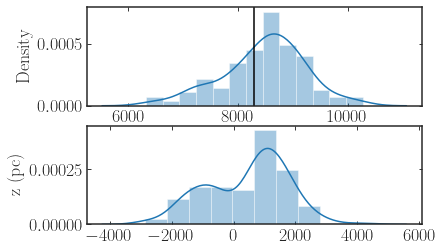

In [24]:
fig, (ax, ax1)=plt.subplots(nrows=2)

sns.distplot(r.value, ax=ax)

sns.distplot(z.value, ax=ax1)

ax.axvline(8300, c='k')

ax.set_xlabel('R (pc)')
ax1.set_ylabel('z (pc)')

In [25]:
len(z[abs(z.value) > 1000.]), len(z[abs(z.value) <= 1000.])

(106, 76)

In [26]:
fdf=ucds.sort_values(by='spt')[['grism_id', 'distance', 'spt','spectra']]

In [27]:
latc_df=pd.DataFrame()

In [28]:
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['designation']=fdf.spectra.apply(lambda x: x.designation.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper())
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: splat.typeToNum(x.spectral_type[0]) +r'$\pm$'+ str(x.spectral_type[1]))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x:  str(round(x.mags['F110W'][0],3)) +r'$\pm$'+ str(round(x.mags['F110W'][1],3)))
#latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x:  str(round(x.mags['F140W'][0],3)) +r'$\pm$'+  str(round(x.mags['F140W'][1],3)))
#latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x:   str(round(x.mags['F160W'][0],3)) + r'$\pm$'+ str(round(x.mags['F160W'][1],3)))
#latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(lambda x: str(int(round(x.distance['val'].value, 0)))  + r'$\pm$'+ 
                                                 str((int(round(x.distance['er'].value, 0)))))

In [29]:
latc_df=latc_df.replace('nan$\\pm$nan', 'nodata')

In [30]:
#get the right sequence of coplumns
col_list=['designation','grism id', 'ra', 'dec', 'f110', 'f140', 'f160', 'snrj', 'spt', 'distance']

In [31]:
latc_df[col_list].to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [32]:
fdf=fdf.reset_index(drop=True)

#########################

In [33]:
spdwarf=splat.searchLibrary(giant=False, ucd=True, binary=False)
spdwarf.shortname=spdwarf.DESIGNATION.apply(splat.designationToShortName)
spdwarf=spdwarf[~ ( spdwarf.shortname.isin(wisps.FORBIDDEN_LIST)
               | (spdwarf.H_2MASS_E > 0.4) | (spdwarf.J_2MASS_E > 0.4) | (spdwarf.MEDIAN_SNR <3) )]
#spdwarf=spdwarf[~spdwarf.]
spdwarf.SPEX_TYPE=spdwarf.SPEX_TYPE.apply(wisps.make_spt_number)

In [34]:
def format_jk_zhang(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if row['J'] !='none':
        #print ((row['J']).split('±'))
        #row['J_mag']=(row['J']).split('±')[0]
        #row['J_er']=(row['J']).split('±')[-1]
        jmag=(row['J']).split('±')[0]
        jmag_er=(row['J']).split('±')[1]
        
    if row['H'] !='none':
        #print ((row['H']).split('±'))
        #row['H_mag']=(row['H']).split('±')[0]
        #row['H_er']=(row['H']).split('±')[-1]
        hmag=(row['H']).split('±')[0]
        hmag_er=(row['H']).split('±')[1]
        
    spt=splat.typeToNum(row[' SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

def format_jk_manj(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if str(row['J (mag)']) !='nan':
        #ignore others
        if not str(row['J (mag)']).startswith('>'):
            jmag=((row['J (mag)']).split('+or-')[0]).strip()
            jmag_er=((row['J (mag)']).split('+or-')[1]).strip()

    if str(row['H (mag)']) !='nan':
        if not str(row['J (mag)']).startswith('>'):
            hmag=(row['H (mag)']).split('+or-')[0]
            hmag_er=(row['H (mag)']).split('+or-')[1]
        
    spt=splat.typeToNum(row['SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

In [35]:
fdf=ucds
pols=wisps.POLYNOMIAL_RELATIONS
color_pol=pols['colors']

In [36]:
#zhang
zhng=pd.read_csv('~/research/wisps/data/zhang_data.csv')
zhng_clrs=zhng.apply(format_jk_zhang, axis=1 ).applymap(float)

In [37]:
#manjavacas
man_df0=pd.read_csv('/users/caganze/research/wisps/data/manjavaca_phot.txt', sep='\t',  index_col=None)
man_clrs=man_df0.apply(format_jk_manj, axis=1 ).applymap(float)

In [38]:
man_clrs.columns

Index(['H', 'J', 'H_er', 'J_er', 'SpTn'], dtype='object')

In [39]:
fdf['J']=fdf['F140W']+color_pol['j_f140'][0](fdf['spt'])
fdf['J_er']=(fdf['F140W_er']**2+color_pol['j_f140'][1]**2)**0.5

fdf['H']=fdf['F160W']+color_pol['h_f160'][0](fdf['spt'])
fdf['H_er']=(fdf['F160W_er']**2+color_pol['h_f160'][1]**2)**0.5

In [40]:
fdf['J_110']=fdf['F110W']+color_pol['j_f110'][0](fdf['spt'])
fdf['J_110_er']=(fdf['F110W_er']**2+color_pol['j_f110'][1]**2)**0.5

In [41]:
ucd_wisp=fdf[fdf.grism_id.str.startswith('par')]
ucd_hst3d=fdf[~fdf.grism_id.str.startswith('par')]

In [42]:
#remove planets
man_clrs=man_clrs[abs(man_clrs['H']-man_clrs['J']<2)]
spdwarf=spdwarf[(spdwarf['J_2MASS']-spdwarf['H_2MASS']<2) &(spdwarf.SPEX_TYPE >=17.)]

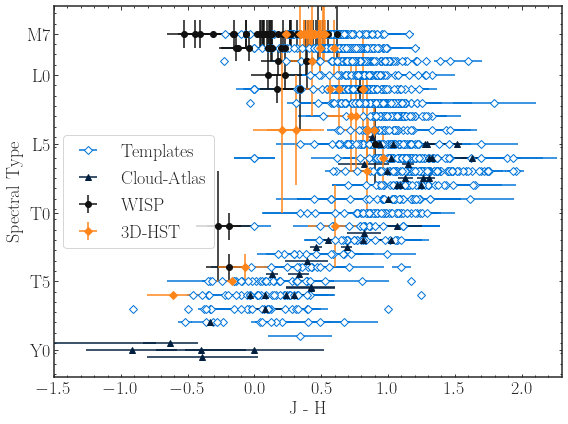

In [43]:
fig, ax=plt.subplots(figsize=(8, 6))



ax.errorbar(spdwarf['J_2MASS']-spdwarf['H_2MASS'], spdwarf.SPEX_TYPE, fmt='D', 
            xerr=(spdwarf.J_2MASS_E**2+spdwarf.H_2MASS_E**2)**0.5, color='#0074D9', 
            mfc='white',  label='Templates')

#ax.errorbar(spsubdwarf['J_2MASS']-spsubdwarf['H_2MASS'],spsubdwarf.SPEX_TYPE, fmt='D', 
#            xerr=(spsubdwarf.J_2MASS_E**2+spsubdwarf.H_2MASS_E**2)**0.5, color='#2ECC40', mfc='white', label='Spex Subdwarfs')

ax.errorbar(-man_clrs['J']+man_clrs['H'], man_clrs['SpTn'], fmt='^', 
            xerr=(man_clrs['J_er']**2+man_clrs['H_er']**2)**0.5, color='#001f3f', label='Cloud-Atlas')

#ax.errorbar(-zhng_clrs['J']+zhng_clrs['H'],zhng_clrs.SpTn, fmt='*', 
#            xerr=(zhng_clrs.J_er**2+zhng_clrs.H_er**2)**0.5, color='#FF4136', label='Primeval')



ax.errorbar(ucd_wisp['J_110']-ucd_wisp['H'], ucd_wisp['spt'], fmt='o', 
            xerr=(ucd_wisp['J_110_er']**2+ucd_wisp['H_er']**2)**0.5, 
            yerr=ucd_wisp['spt_er'], color='#111111', label=r'WISP')

ax.errorbar(ucd_hst3d['J']-ucd_hst3d['H'], ucd_hst3d['spt'], fmt='D',
            xerr=(ucd_hst3d['J_er']**2+ucd_hst3d['H_er']**2)**0.5, 
            yerr=ucd_hst3d['spt_er'], color='#FF851B', label=r'3D-HST')


ax.set_ylim([15, 42])
ax.set_xlim([-1.5, 2.3])
ax.invert_yaxis()


ax.set_yticks([17, 20, 25, 30, 35, 40])
ax.set_yticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])


ax.minorticks_on()
ax.set_ylabel('Spectral Type', fontsize=18)
ax.set_xlabel(r'J - H', fontsize=18)

ax.legend(fontsize=18)
#mplcyberpunk.make_lines_glow(ax)
#plt.grid(which='both', color='#7FDBFF')
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/color_color_plots.pdf', bbox_inches='tight')


In [44]:
wispsucd=ucds[ucds.grism_id.str.lower().str.startswith('par')]
hst3ducd=ucds[~ucds.grism_id.str.lower().str.startswith('par')]

In [45]:
older_pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_corrected.pkl')
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_uncorrected.pkl')
maglimits=pd.DataFrame([x.mag_limits for x in pnts])

In [46]:
MAX_LTS=maglimits.max()[['F110', 'F140', 'F160']].values
MED_LTS=maglimits.median()[['F110', 'F140', 'F160']].values

In [47]:
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections']

In [48]:
sp_grid=np.arange(15, 40)

d_limitsdict=(pd.DataFrame([wisps.distance({'F110W': (MED_LTS[0], 0.5), 'F140W': (MED_LTS[1], 0.5), 
                                            'F160W': (MED_LTS[2], 0.5)}, x, 0.) 
                        for x in sp_grid])[['distF110W', 'distF140W', 'distF160W']]).apply(lambda x: np.nanmean(x), axis=1)


corrected_limits=(pd.DataFrame([wisps.distance({'F110W': (MAX_LTS[0], 0.5), 'F140W': (MAX_LTS[1], 0.5), 
                                            'F160W': (MAX_LTS[2], 0.5)}, x, 0.)
                        for x in sp_grid])[['distF110W', 'distF140W', 'distF160W']]).apply(lambda x: np.nanmean(x), axis=1)


new_corrected_limits=(pd.DataFrame([wisps.distance({'F110W': (MAX_LTS[0]+(corr_pols['F110W'][0])(x), 0.5), 
                                                    'F140W': (MAX_LTS[0]+(corr_pols['F110W'][0])(x), 0.5), 
                                                    'F160W': (MAX_LTS[0]+(corr_pols['F110W'][0])(x), 0.5)},
                                                   x, 0.) 
                        for x in sp_grid])[['distF110W', 'distF140W', 'distF160W']]).apply(lambda x: np.nanmean(x), axis=1)


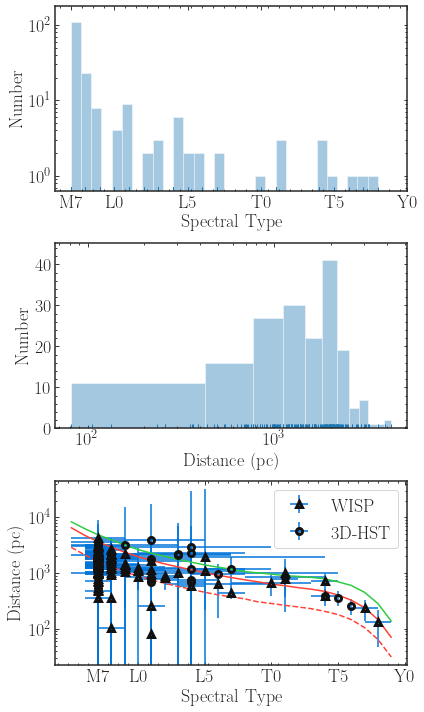

In [49]:
fig, (ax, ax1, ax2)=plt.subplots(nrows=3, figsize=(6, 10))
sns.distplot(ucds.spt, kde=False, ax=ax, rug=True, hist_kws={'align': 'mid'})
ax.set_xlabel('Spectral Type', fontsize=18)
ax.set_ylabel('Number', fontsize=18)
ax.minorticks_on()
ax.set_yscale('log')


sns.distplot(ucds.distance, kde=False, ax=ax1, rug=True, hist_kws={'align': 'mid'})
plt.tight_layout()
ax1.set_xlabel('Distance (pc)', fontsize=18)
ax1.set_ylabel('Number', fontsize=18)
ax1.minorticks_on()
ax1.set_xscale('log')

#for a in [ax, ax1]:
ax.set_xticks([17, 20, 25, 30, 35, 40])
ax.set_xticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])



ax2.plot(sp_grid, d_limitsdict.values, c='#FF4136', linestyle='--')
ax2.plot(sp_grid,  corrected_limits.values, c='#FF4136')
ax2.plot(sp_grid, new_corrected_limits.values, c='#2ECC40')

ax2.errorbar(wispsucd.spt, wispsucd.distance, yerr=wispsucd.distance_er , xerr= wispsucd.spt_er, label='WISP', fmt='^',  
             mec='#111111', mfc='none', mew=3, rasterized=True, c='#0074D9')
ax2.errorbar(hst3ducd.spt, hst3ducd.distance, yerr=hst3ducd.distance_er , xerr= hst3ducd.spt_er, label='3D-HST', fmt='o',
             mec='#111111',  mfc='none', mew=3, rasterized=True, c='#0074D9')
ax2.legend()


ax2.set_yscale('log')
ax2.set_ylabel('Distance (pc)', fontsize=18)
ax2.set_xlabel('Spectral Type', fontsize=18)

ax2.minorticks_on()

ax2.set_xticks([17, 20, 25, 30, 35, 40])
ax2.set_xticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/sptdistribution.pdf',  bbox_inches='tight')

[21.  0.]


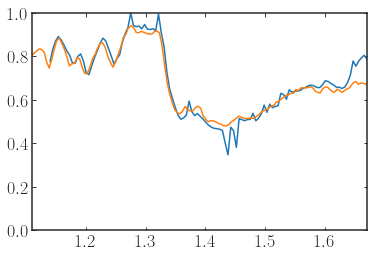

In [50]:
s=np.random.choice(ldwarfs.spectra.values)

m=s.flux[np.logical_and(s.wave >1.2, s.wave<1.65)].max()

std= splat.STDS_DWARF_SPEX[splat.typeToNum(s.spectral_type[0])]

std.normalize(waverange=[1.2, 1.6])


med0=(s.flux[np.logical_and(s.wave >1.2, s.wave <1.6) ]).mean()
med1=(std.flux.value[np.logical_and(std.wave.value >1.2, std.wave.value <1.6) ]).mean()

std.scale(med0/med1)
plt.plot(s.wave, s.flux)
plt.plot(std.wave.value, std.flux.value)
plt.xlim(1.11, 1.67)
plt.ylim([0., m])
print (s.spectral_type)

In [51]:
ldwarfs.spt_er.median()

2.0

In [52]:
#import mplcyberpunk

#plt.style.use("cyberpunk")

fig, ax=plt.subplots(figsize=(7, 14))

for  idx, y in enumerate(tdwarfs.spectra):
    x=y.splat_spectrum
    
    if x.wave.value.min()< 0.9:
        x.trim([0.88, 1.7])
        
    if x.wave.value.min()>0.9:
        x.trim([1.1, 1.7])
  
    std= splat.STDS_DWARF_SPEX[splat.typeToNum(y.spectral_type[0])]
    
    std.normalize(waverange=[1.15, 1.65])
    x.normalize(waverange=[1.15, 1.65])
    

    
    med0=(x.flux.value[np.logical_and(x.wave.value >1.15, x.wave.value <1.65) ]).mean()
    med1=(std.flux.value[np.logical_and(std.wave.value >1.15, std.wave.value <1.65) ]).mean()
    
    std.scale(med0/med1)
    
    plt.text(1.4, (x.flux.value+idx/1.5).mean(),splat.typeToNum(y.spectral_type[0]),
             {'fontsize':17, 'weight': 'bold'}, color='#0074D9')
    
    
    plt.step(x.wave.value, x.flux.value+idx/1.5, c='#0074D9')
    plt.plot(std.wave.value, std.flux.value+ idx/1.5, c='#01FF70')
    plt.ylim([0., 8.05])
    plt.xlim([0.85, 1.7])
    
plt.minorticks_on()
 
#mplcyberpunk.make_lines_glow(ax)
    
ax.set_xlabel(r'$\lambda$ ( micron)', fontsize=24)
ax.set_ylabel(r'Normalized Flux + offset', fontsize=24)

plt.tight_layout()  
#mplcyberpunk.add_underglow()
#mplcyberpunk.make_lines_glow(ax)
plt.savefig(wisps.OUTPUT_FIGURES+'/tdwarfsequence.pdf')

In [53]:
def select_by_indices(df, idx, spt_range):
    print(spt_range)
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==spt_range][0]
    _, bools= bx._select(np.array([df[idx.xkey].values, df[idx.ykey].values]))
    return bools

def selected_by_rf(df)

SyntaxError: invalid syntax (<ipython-input-53-3a079e89275d>, line 8)

In [ ]:
import wisps.data_analysis.selection_criteria as sel_crt
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
slc_crts=sel_crt.crts_from_file()

In [ ]:
rfselection=pd.read_csv(wisps.OUTPUT_FILES+'/selected_by_rf.csv')
nnres=pd.read_pickle(wisps.OUTPUT_FILES+'/deep_neural_net_classifier_results.pkl')

In [ ]:
rfselection.shape

In [ ]:
nnsel= pd.concat(nnres['selected'])

In [ ]:
nnselection =pd.DataFrame()
nnselection['grism_id']=np.concatenate([nnsel.l.values, nnsel.t.values])
nnselection=nnselection.drop_duplicates('grism_id')

In [ ]:
nnselection.shape

In [ ]:
labelled=wisps.Annotator.group_by_spt(ucds, spt_label='spt', assign_number=False)

for idxk, k in indices_to_use:
    idx=slc_crts[idxk]
    labelled['selected_by_{}'.format(k)]= select_by_indices(labelled, idx, k)

In [ ]:
labelled['index_label']=np.logical_or.reduce([labelled['selected_by_{}'.format(x)].values 
                                              for x in  np.vstack(indices_to_use)[:,1]])

In [ ]:
#add labels for index selection
labelled['selected_by_rf']=labelled.grism_id.str.lower().isin(rfselection.grism_id.str.lower())

In [ ]:
for g in labelled.groupby('spt_range'):
    df0=g[1]
    print ('{}'.format(g[0]))
    print ('selected by rf {}'.format(len(df0[df0.selected_by_rf])))
    print ('selected by indices {}'.format(len(df0[df0.index_label])))
    print ('selected by rf and indices {}'.format(len(df0[np.logical_and(df0.index_label,df0.selected_by_rf) ])))
    print ('---------------------------------------------------------------- ')

In [ ]:
ghgjbkn

In [ ]:
len(ucds)

In [ ]:
ucds['f_test']=ucds.spectra.apply(lambda x: x.f_test)
ucds['dof']=ucds.spectra.apply(lambda x: x.dof)
ucds['line_chi']=ucds.spectra.apply(lambda x: x.line_chi)
ucds['spex_chi']=ucds.spectra.apply(lambda x: x.spex_chi)
ucds['wavenumber']=ucds.spectra.apply(lambda x:len(x.wave))

In [ ]:
'''
%%capture
fold='/Users/caganze/research/wisps/figures/ltwarfs/'
ids=0
for idx, row in ucds.iterrows():
    try:
        s=row.spectra
        filename=fold+'spectrum'+str(ids)+'.pdf'
        s.pixels_per_image=100
        s.plot(save=True, filename=filename)
        ids=ids+1
    except:
        s=wisps.Source(filename=row.grism_id.replace('g141', 'G141'),is_ucd=False )
        s.pixels_per_image=100
        filename=fold+'spectrum'+str(ids)+'.pdf'
        s.plot(save=True, filename=filename)
        ids=ids+1
'''

In [ ]:
#ldwarfdata.to_pickle('~/desktop/wispldwarfs.pkl')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')

In [ ]:
ucds.grism_id.to_csv('~/desktop/true_brown_dwarfs.csv')

In [91]:

mdwf=ucds[np.logical_and(ucds.spt_er >1, ucds.spt<20)].spectra.values[-3]

ldwf=ucds[np.logical_and(ucds.spt_er >2, ucds.spt.between(20, 30))].spectra.values[-1]

tdwf=ucds[np.logical_and(ucds.spt_er >2,  ucds.spt.between(30, 40))].spectra.values[-1]

In [100]:
for x in [mdwf, ldwf, tdwf]:
    df=pd.DataFrame()
    df['wave'] = x.wave
    df['flux']= x.flux
    df['noise']=x.noise
    df['grism_id']=x.grism_id.upper()
    
    
    df.to_csv('/users/caganze/desktop/{}.csv'.format(x.grism_id))
    
    #print (df)
    
    
    
    

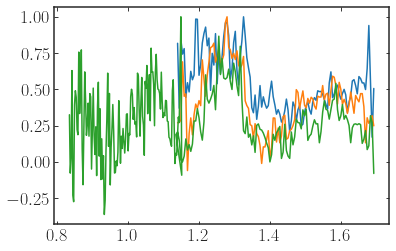

In [102]:
plt.plot(mdwf.wave, mdwf.flux)
plt.plot(ldwf.wave, ldwf.flux)
plt.plot(tdwf.wave, tdwf.flux)
#plt.xlim([1.1, 1.7])
#plt.ylim([0., 1.])
#plt.xlim([1.1, 1.7])
#plt.ylim([0., 1.])